<a href="https://colab.research.google.com/github/inteligenciafrvm/inteligenciafrvm/blob/master/Clases%20pr%C3%A1cticas/4.%20Intro%20al%20aprendizaje%20supervisado%20(clasificaci%C3%B3n%20II).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción al Aprendizaje Supervisado - Clasificación (Parte II)

* Pre-procesamiento de los datos.
* Evaluación de un clasificador.
* FPR vs FNR tradeoff.

5to año - Ingeniería en Sistemas de Información

Facultad Regional Villa María

## Pre-procesamiento de datos

Un problema muy frecuente (en industria es uno de los problemas más reportados en ML) es que los datasets "crudos" no pueden recibir entrenamiento tal como están, por lo que necesitan un pre-procesamiento para poder adaptarse a los requerimientos del modelo. Vemos algunos métodos de pre-procesamiento comunes:



### Eliminación de features que no aportan a la predicción

Un problema común en los datasets es que muchas veces los mismos tienen algunas variables que no están relacionadas de ninguna forma con las salidas o bien es sabido a priori que no aportan información significativa para predecir la salida.

* Un ejemplo común son los identificadores, los cuales asocian cada fila de datos con un único código de identificación.

* Estos features deben eliminarse, porque de lo contrario el modelo los ajustará e intentará hacer predicciones con datos que no tienen aporte alguno, empeorando la calidad general del modelo.

### Ampliación o transformación del dataset

De forma similar, existen maneras de agregar o transformar datos en el dataset para mejorar las predicciones, por ejemplo incorporando información de datasets públicos o generando nuevos features a partir de los existentes o con la ayuda de información de dominio.

* Este tipo de mejoras puede ayudar a mejorar las predicciones del dataset, por ejemplo al poder utilizar features más relevantes para predecir las salidas.

* Al igual que al eliminar los features (más allá de aquellos obvios como los identificadores), no hay una regla general para ampliar el dataset, pues depende mucho del dominio del problema.

* Por ejemplo, en visión por computadoras un pre-procesamiento que se hace algunas veces consiste en pasar las imágenes de RGB a escala de grises para reducir el tamaño de la misma. Por otra parte, una ampliación (*data augmentation*) común consiste en agregar la misma imagen pero rotada hacia la derecha e izquierda.

### Dummy variables para datasets con features no numéricos

* Por ejemplo, si tenemos que hacer una predicción sobre imágenes geométricas y contamos con una variable categórica "Color" en las mismas que toma valores "Rojo", "Azul" y "Verde". Tal variable no puede ser utilizada de esa forma para hacer la predicción, puesto que los modelos emplean features numéricos.
* Una solución rápida consistiría en reemplazar los features asignando, por ejemplo, 0 cuando se trata de "Rojo" , 1 cuando se trata de "Azul" y 2 cuando es "Verde", es decir

|                 | Color  |
|-----------------|:------:|        
| Rectángulo rojo |    0   |
| Círculo azul    |    1   |
| Estrella verde  |    2   |


* El problema de este enfoque es que asumimos arbitrariamente un orden en los features, por lo cual nuestro modelo estaría innecesariamente sesgado en su entrenamiento, estableciendo por ejemplo que "Verde" es el doble que "Azul".
* Un enfoque que a veces se usa para estos casos consiste en crear un nuevo feature para cada valor categórico posible, asignando un 1 cuando el valor pertenece a la mencionada categoría y un 0 para todas las demás categorías.
* Esta transformación se conoce como "one-hot encoding", y las variables de esta forma reciben el nombre de "dummy variable".

|                 | Rojo  | Azul  |Verde|
|-----------------|:-----:|:-----:|:---:|
| Rectángulo rojo |   1   |   0   |  0  |
| Círculo azul    |   0   |   1   |  0  |
| Estrella verde  |   0   |   0   |  1  |

Ejemplo en código:

In [1]:
import pandas as pd

df = pd.DataFrame([['rojo' , 'a', 2  , 1], 
                   ['rojo' ,'b',  2  , 1], 
                   ['verde','b',  1  , 1], 
                   ['azul' ,'a',  3  , 2], 
                   ['verde','c',  1.5, 1]], 
                  columns=['color', 'letra', 'alto', 'ancho'])
print(df)

   color letra  alto  ancho
0   rojo     a   2.0      1
1   rojo     b   2.0      1
2  verde     b   1.0      1
3   azul     a   3.0      2
4  verde     c   1.5      1


In [2]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
df_one_hot = encoder.fit(df[['color', 'letra']])
print(df_one_hot.categories_)

[array(['azul', 'rojo', 'verde'], dtype=object), array(['a', 'b', 'c'], dtype=object)]


In [3]:
features_transformados = df_one_hot.transform(df[['color', 'letra']]).toarray()

print(df_one_hot.get_feature_names(['color', 'letra']))
print(features_transformados)

['color_azul' 'color_rojo' 'color_verde' 'letra_a' 'letra_b' 'letra_c']
[[0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1.]]


In [4]:
# también podemos hacer la transformación inversa

print(df_one_hot.inverse_transform(features_transformados))

[['rojo' 'a']
 ['rojo' 'b']
 ['verde' 'b']
 ['azul' 'a']
 ['verde' 'c']]


Anexamos nuestro one-hot encoding a los datos originales

In [5]:
import numpy as np

datos_numericos = df[['alto', 'ancho']]
datos_completos = np.hstack((datos_numericos, features_transformados))
print(datos_completos)

[[2.  1.  0.  1.  0.  1.  0.  0. ]
 [2.  1.  0.  1.  0.  0.  1.  0. ]
 [1.  1.  0.  0.  1.  0.  1.  0. ]
 [3.  2.  1.  0.  0.  1.  0.  0. ]
 [1.5 1.  0.  0.  1.  0.  0.  1. ]]


#### Desventajas:

One-hot encoding no es necesario, o puede causar un decremento de la performance cuando:
* Usamos métodos basados en árboles como *decision trees* o *random forest*.
* Tenemos sólo dos valores posibles para la variable categórica.
* Aumentaría muy considerablemente la cantidad de dimensiones. En esos casos tenemos que evaluar otras opciones como crear features a mano que agrupen lo que queremos representar en una forma que tenga sentido en el dominio de los datos.

### Normalización de los datos

En virtud de que todos los features **contribuyan de forma equitativa** (es decir que no tengan más peso en la clasificación aquellos features con mayor magnitud), para algunos modelos se requiere que los datos estén normalizados de alguna forma, por ejemplo para que todos los valores caigan en el mismo rango fijo. La normalización se hace en cada feature. Informalmente, "para cada columna".


* Una normalización posible es **minmax normalization**, la cual transforma un feature de tal forma que todos sus valores caigan en el rango $[0,1]$.
* Para lograr esto es suficiente hacer, para cada elemento $j$ del feature $X_i$

$$Z_{ij} = \frac{X_{ij} - min(X_{i})}{max(X_{i}) - min(X_{i})}$$



Ejemplo: dados los siguientes datos,

| Feature_1 |
|:---------:|
| 42        |
| 66        |
| 187       |
| 29        |

Normalizando...

| Feature_1 |
|:---------:|
| 0.08      |
| 0.23      |
| 1         |
| 0         |

* Otra normalización muy común es la **z-score standarization**, normaliza los valores con respecto a la desviación estándar, dejando los mismos con media 0. Analíticamente, $$Z_{ij} = \frac{X_{ij} - \bar{X}}{\sigma}$$ donde $\bar{X}$ es la media de la población y $\sigma$ es la desviación estándar.

* Cada valor $Z_{ij}$ normalizado representa la distancia entre el valor $X_{ij}$ y la media de la población, en $Z_{ij}$ desviaciones estándar como unidad.

Normalizando los datos iniciales del ejemplo el ejemplo anterior...

| Feature_1 |
|:---------:|
| 42        |
| 66        |
| 187       |
| 29        |

Media = 81;
desviación estándar = 72.3

| Feature_1 |
|:---------:|
|-0.62      |
|-0.23      |
| 1.69      |
|-0.83      |

Librerías de ejemplo para ambas normalizaciones:

* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

#### A tener en cuenta en la normalización

##### **1.** ¿Qué sucede cuando queremos normalizar y tenemos que dividir los datos en train y test (o, análogamente, en train y validation)?

Si normalizamos toda nuestra matriz de datos X, tendremos un problema: estaremos sesgando indirectamente nuestro entrenamiento con respecto a los conjuntos de test y de validación.

Lo que se hace en estos casos es:

1. Obtener $\bar{X}_{train}$ y $\sigma_{train}$ para el caso de normalización z-score, o $min(X_i)_{train}$ y $max(X_i)_{train}$ para el caso de minmax.
2. Aplicar la normalización al conjunto de entrenamiento.
3. Al hacer predicciones, normalizar el conjunto de validación o test **con respecto a los estadísticos del conjunto de entrenamiento**, es decir $\bar{X}_{train}$ y $\sigma_{train}$ (para el caso de z-score). Es decir que para normalizar el conjunto de test, hacemos para cada uno de sus $X_{ij}$:

$$Z_{ij} = \frac{X_{ij} - \bar{X}_{train}}{\sigma_{train}}$$

Naturalmente, si hacemos esto perderemos alguna de las propiedades de la normalización para el conjunto de test (por ejemplo, en el caso de z-score, es muy probable que la media y desviación de los datos de test difieran de 0 y 1, respectivamente), pero esto es totalmente preferible antes que sesgar el conjunto de entrenamiento.

Nota: ambas librerías de ejemplo conservan los estadísticos originales.

##### **2.** Tener en cuenta que hay modelos que no son afectados por ciertas normalizaciones

## Evaluando un clasificador

La forma más simple de evaluar un clasificador es mediante el porcentaje o **tasa de aciertos**, es decir qué porcentaje de nuestras predicciones acertaron la clase, dados todos los puntos consultados.

* Retomamos el ejemplo de la clase pasada:

In [6]:
from sklearn.datasets import load_iris
from sklearn import neighbors
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data[:, :2]
y = iris.target

# Dividimos el conjunto en train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=80, test_size=0.3)


clf = neighbors.KNeighborsClassifier(n_neighbors=5)

clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print(y_hat)

[0 0 0 2 0 2 2 0 0 0 2 2 1 0 2 1 0 1 0 0 0 2 2 1 2 0 1 1 1 2 0 1 0 1 1 1 0
 2 1 0 0 0 2 2 2]


In [7]:
print('Porcentaje de aciertos en la clasificación: ', clf.score(X_test,y_test))

Porcentaje de aciertos en la clasificación:  0.7555555555555555


* Esta métrica es una buena medida para saber rápidamente los aciertos en todo clasificador. Sin embargo no nos está dando detalles como, por ejemplo, que todas las Setosas fueron correctamente clasificadas. Para ello vamos a usar mejor información, que incluya las métricas comúnmente utilizadas para evaluar un clasificador.

#### Tipos de errores

En la clasificación binaria (es decir cuando la cantidad de clases posibles a la que una variable puede pertenecer es de dos), al intentar hacer una predicción, existen dos tipos de errores de predicción a considerar.

Por ejemplo, supongamos que testeamos la existencia de una enfermedad en un paciente. Como _hipótesis nula_ $h_0$ tomamos a "$h_0$: el paciente no posee la enfermedad", mientras que como _hipótesis alternativa_ tomamos "$h_1$: el paciente posee la enfermedad".

* $h_0$ es la hipótesis que se suele usar para establecer **"ausencia o inexistencia de relación entre dos fenómenos"** (tomando como fenómenos "el paciente" y "la enfermedad"), mientras que $h_1$ representa **"algún tipo de relación entre dos fenómenos"**.

* "_Inocente hasta que se demuestre lo contrario_". En testing de hipótesis, $h_0$ es la postura por defecto. Esto quiere decir que para rechazarla y por lo tanto validar una hipótesis alternativa debe demostrarse fehacientemente que $h_0$ es falsa más allá de toda duda razonable (normalmente representada por un intervalo de confianza del 95%).

* El **error de tipo I**, **false positive** o **falsa alarma** ocurre cuando se rechaza incorrectamente una $h_0$ verdadera. En nuestro ejemplo, esto sucede cuando incorrectamente diagnosticamos la enfermedad en el paciente.

* Por otra parte, el **error de tipo II**, **false negative** o **detección perdida**, ocurre cuando incorrectamente se retiene una $h_0$ falsa, siendo que se daba la relación establecida por $h_1$. En nuestro ejemplo esto sucede cuando detectamos incorrectamente que el paciente no registra la enfermedad.

* En el caso de que la predicción haya sido correcta, decimos que la misma arrojó un **true positive** o **true negative**, según si se predijo correctamente la existencia o no de la relación entre dos fenómenos (_positive_ significa que dicha relación existió, es decir que se cumple $h_1$).

* En nuestro caso, true positive representa la correcta predicción en la existencia de la enfermedad mientras que false positive representa correctamente la predicción sobre la ausencia de la enfermedad.

* En nuestro ejemplo, si detectáramos varias enfermedades en el paciente y nos interesa saber $h_0$, true negative se referirá a los casos donde predecimos que el paciente no posee ninguna enfermedad y tal situación es la real; mientras que true positive se refiere a haber inferido correctamente que el paciente posee alguna enfermedad. Este enfoque se conoce como **one-vs-all**.

#### Confusion Matrix

Una forma sencilla de evaluar el rendimiento de un algoritmo es por medio de una **confusion matrix** o **error matrix**, la cual contrasta las predicciones con los valores verdaderos, mostrando los errores TI y TII.

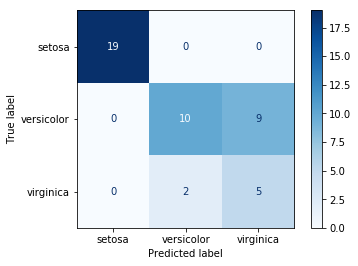

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test,
                      display_labels=iris.target_names,
                      cmap=plt.cm.Blues)
plt.show()

Versión normalizada de acuerdo a la cantidad de observaciones:

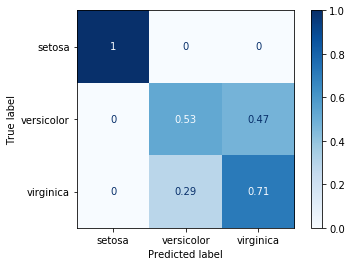

In [9]:
plot_confusion_matrix(clf, X_test, y_test,
                      display_labels=iris.target_names,
                      cmap=plt.cm.Blues,
                      normalize='true')
plt.show()

* En el caso de la **clasificación muticlase**, para algunos algoritmos o cálculo de métricas se usa la estrategia "one-vs-all" para referirse a los tipos de errores. Es decir que cada tipo de error es calculado para cada una de las clases, tomando un label de dicha clase como positivo ($y=1$) y un label de cualquier otra clase como negativo ($y=0$). 

* Ejemplo: clasificación multiclase desde las setosas



|                   |                    |     Clase estimada      |                            |
|-------------------|--------------------|:-----------------------:|:--------------------------:|
|                   |                    | No Setosa ($\hat{y}=0$) |    Setosa ($\hat{y}=1$)    |
|                   | No Setosa ($y=0$)  |       **1**            |             0              |
|**Clase verdadera**| Setosa    ($y=1$)  |          0              |          **1**            |

* Esto se hace para poder extender el problema a partir de una clasificación binaria, pudiendo evaluar los errores TI y TII de la misma forma.

* Vemos ahora con mejor nivel de detalle aspectos como que todas las flores Setosa utilizadas para el test fueron correctamente clasificadas, mientras que las flores Versicolor se confunden frecuentemente con las Virginica.

Vamos a procesar todavía más esta información al calcular métricas adicionales que nos permitirán obtener más claridad.


Vista general: de todos los puntos (representada por un rectángulo, que divide los positivos de los negativos) elegimos una determinada cantidad de puntos como positivos (representada por el círculo central)

![Positives - Negatives](images/4/positives_negatives.png)

Fuente: Walber (usuario de Wikipedia), imagen adaptada desde https://en.wikipedia.org/wiki/Precision_and_recall

Concepto preliminar: en la clasificación binaria, es decir aquellos problemas donde $c_i \in \{False, True\}$, el **umbral** o _threshold_ $\theta \in [0,1]$ es la probabilidad mínima que hace que el predictor clasifique una observación como True. Aquellas probabilidades por debajo del umbral son clasificadas como False.

(nota: no confundir $\theta$ utilizado en el resto del notebook para denotar un umbral con $\theta$ comúnmente utilizado para referirse a los parámetros del predictor)

Por ejemplo, para clasificar un positivo con un $\theta = 0.75$ se necesita que $P(y=1 \mid x) > 0.75$.

#### Métricas desde el punto de vista de los negativos




La primera métrica es el **false positive rate (FPR)** (o proporción de falsas alarmas), que representa el porcentaje de errores de TI en la clasificación, es decir

$$ FPR = \frac{FP}{\text{actual negatives}} = \frac{FP}{FP + TN}$$

Un predictor no tendría falsas alarmas si clasificara todo como "False", al usar un umbral $\theta=1$.

Por otra parte, el **false negative rate (FNR)** (o proporción de detecciones perdidas) representa el porcentaje de errores TII en la clasificación, es decir

$$ FNR = \frac{FN}{\text{actual positives}} = \frac{FN}{FN + TP}$$

Un predictor no tendría detecciones perdidas si clasificara todo como "True", usando un umbral $\theta = 0$.

#### Métricas desde el punto de vista de los positivos

![](images/4/precision_recall.png)

Fuente: Walber (usuario de Wikipedia), imagen adaptada desde https://en.wikipedia.org/wiki/Precision_and_recall

Uno de los indicadores principales es el **positive predictive value** o **precision**, que representa el porcentaje de positivos correctamente inferidos como tal por cada positivo inferido. Está dado por

$$P(y=1 \mid \hat{y}=1) = \frac{TP}{\text{predicted positives}} = \frac{TP}{TP + FP}$$

Intuitivamente puede interpretarse como **"qué tan seguro es un clasificador al inferir las observaciones como positivas"**. Un predictor maximizaría esta métrica si clasificara como "True" sólo aquellas observaciones con las que cuente con total certeza que son "True".

Otro indicador principal es el **true positive rate**, **sensitivity** o **recall**, que representa el porcentaje de positivos correctamente inferidos por cada positivo real, dado por

$$P(\hat{y}=1 \mid y=1)= \frac{TP}{\text{actual positives}} = \frac{TP}{TP + FN}$$

Intuitivamente puede interpretarse como **"qué tan bueno es un clasificador en detectar los positivos"**. Un predictor sería perfecto en la detección de positivos si clasificara todo como "True", al usar un umbral $\theta = 0$.

Análogamente, el **true negative rate** o **specificity** es similar al recall pero considerando los negativos, es decir

$$P(\hat{y}=0 \mid y=0)= \frac{TN}{\text{actual negatives}} = \frac{TN}{TN + FP}$$

Intuitivamente puede interpretarse como "qué tan bueno es un clasificador evitando las falsas alarmas". Como vimos antes, un predictor sería perfecto en evitar falsas alarmas si clasificara todo como "False", es decir usara un $\theta=1$.

La primera medida que venimos usando, el porcentaje de aciertos (**accuracy**) está dada por

$$\text{accuracy} = \frac{\text{correctly predicted}}{\text{all predicted}} = \frac{TP + TN}{TP + FP + TN + FN}$$

Como es trivial y poco útil maximizar precision o recall por separado, un buen clasificador debería, en general (y dependiendo del problema que trata de resolver), intentar maximizar conjuntamente tanto precision como recall. Normalmente ambos representan intereses contrapuestos.

* Por ejemplo: imaginemos un clasificador en el dominio criminal, donde tenemos sospechosos y evidencias hacia ellos, y buscamos maximizar tanto que los sospechosos culpables sean identificados como tales (recall), como la seguridad de nuestro clasificador al afirmar culpabilidad de un sospechoso (precision), de modo de minimizar la cantidad de inocentes con condena injusta.

* En este caso, la hay posturas en filosofía del derecho que realizan una clara distinción en este balance, como por ejemplo el [Blackstone's ratio](https://en.wikipedia.org/wiki/Blackstone's_ratio): "*It is better that ten guilty persons escape than that one innocent suffer*" 

* En el caso de que querramos comparar ambas métricas con respecto a la otra en forma equitativa, para evaluarlas conjuntamente se suele usar el F1 score, dado por la media armónica

$$f_1 = \frac{2}{P^{-1}+R^{-1}}$$

Scikit-learn convenientemente hace este procesamiento por nosotros, como vemos a continuación:

In [10]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_hat, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       0.83      0.53      0.65        19
   virginica       0.36      0.71      0.48         7

    accuracy                           0.76        45
   macro avg       0.73      0.75      0.71        45
weighted avg       0.83      0.76      0.77        45



Notar que _support_ es la cantidad de instancias (true values) de cada una de las clases.

## False positive vs false negative tradeoff

Como acabamos de ver, la contraposición de intereses en un clasificador se da porque existe una relación inversa entre los errores false positive (falsa alarma) y los errores false negative (detección perdida).

* La inclinación que querramos darle a este tradeoff depende del problema que estemos intentando resolver.

* Para aquellas tareas que se desempeñan en entornos con aversión al riesgo, por ejemplo al decidir si las pruebas contra un sospechoso son suficientes para afirmar su culpabilidad, debemos diseñar nuestro clasificador de tal forma que se minimicen los costos totales producidos por los errores de predicción.

* En la clasificación binaria, una de las opciones es incluir una **reject region**, es decir un umbral de probabilidad donde el predictor, en lugar de clasificar como False, no tomará decisiones, dejando las mismas en manos de una persona, por ejemplo.

![](images/4/reject_region.png)

Fuente: Figura 1.26 de Bishop 2006a

Alternativamente, si queremos tomar esa decisión pero que nuestro clasificador sea conservador debido al posible costo de los errores, podemos usar el mismo umbral para definir hasta cuánto debe ser nuestro grado de seguridad para asegurar o rechazar $h_0$.

* En los clasificadores probabilísticos vistos aquí, el umbral es establecido al ver la probabilidad de predicción de as distintas clases, y alterando la clase elegida cuando la misma no supera el umbral.

* Por defecto, el umbral utilizado en los clasificadores binarios es $\theta=0.5$, mientras que en los clasificadores multi-clase se selecciona la clase para la cuál nuestro clasificador arroja mayor probabilidad.

* Veamos las probabilidades de nuestro kNN para el dataset iris...

In [11]:
print(clf.predict_proba(X_test[:10,:])) 

# cada una de las columnas de salida representa la probabilidad estimada por el clasificador 
# para cada una de las clases, para las primeras 10 filas de datos. 

[[1.  0.  0. ]
 [1.  0.  0. ]
 [1.  0.  0. ]
 [0.  0.2 0.8]
 [1.  0.  0. ]
 [0.  0.4 0.6]
 [0.  0.4 0.6]
 [1.  0.  0. ]
 [1.  0.  0. ]
 [1.  0.  0. ]]


No obstante, en determinadas situaciones es deseable cambiar el umbral, por ejemplo...

1. Deseamos testear la certeza con la que nuestro clasificador toma las decisiones.
2. Los errores FP y FN tienen una incidencia distinta en el problema para el cuál utilizamos el clasificador, para lo cuál es necesario cambiar $\theta$ en consecuencia.

Analizamos el primer caso. El segundo caso se encuentra analizado en el [Material Extra](https://github.com/inteligenciafrvm/inteligenciafrvm/blob/master/Archivo%20y%20extras/Material%20Extra/Clasificaci%C3%B3n%20II%20-%20Minimizar%20error%20cambiando%20umbrales/Clasificaci%C3%B3n%20II%20-%20Minimizar%20error%20cambiando%20umbrales.ipynb):

> 1\. Deseamos testear la certeza con la que nuestro clasificador toma las decisiones.

### Receiver operating characteristic (ROC) curve

* Los umbrales también pueden utilizarse para evaluar con qué margen de confianza nuestro clasificador infiere la clase de cada una de las observaciones, para de esta manera poder compararlo mejor frente a otros clasificadores en cuanto a su capacidad de generalizar.

* Por ejemplo, el clasificador A y el clasificador B pueden tener idénticas predicciones para un dataset, pero A estar clasificando a todas las clases con un 95% de probabilidad y B estar clasificando con un 51%.

* Distinguir entre ambos clasificadores es precisamente la idea de las curvas ROC. En ellas se muestra cómo se comparan los distintos clasificadores en términos de TPR y FPR con respecto a la suposición aleatoria (elige clase 0 o 1 aleatoriamente) y al clasificador perfecto, mostrando el equilibrio entre true positives y false positives para las distintas instancias.



* Veamos cómo se ve una curva ROC para nuestro ejemplo (armado a partir de https://github.com/reiinakano/scikit-plot).

In [12]:
# instalamos la dependencia requerida

from IPython.display import clear_output

try: # try usado porque la invocación de pip cambia según la versión del mismo
    from pip import main as pipmain # pip 9
except:
    from pip._internal import main as pipmain # pip 10

from IPython.display import clear_output

pipmain(["install", "scikit-plot"])
clear_output()

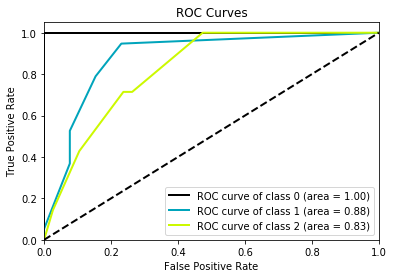

In [13]:
import scikitplot as skplt

y_hat_probas = clf.predict_proba(X_test)

# predicted probabilities generated by sklearn classifier
# Notar que micro-average ROC curve es el promedio de las áreas de las curvas ROC, 
# mientras que macro-average ROC curve es el mismo promedio pero ponderado por la 
# cantidad de observaciones de cada clase.
skplt.metrics.plot_roc(y_test, y_hat_probas, plot_micro=False, plot_macro=False)
plt.show()

* Para comparar la calidad de las curvas ROC, una medida utilizada es comparar su área bajo la curva de cada clasificador.

* Notar que cualquier clasificador puede alcanzar el límite inferior izquierdo (TPR=FPR=0) al setear $\theta=1$ y por lo tanto clasificar todo como 0. Análogamente, setear $\theta=0$ hará que todos los resultados sean clasificados como 1, obteniendo (TPR=FPR=1).

* Trazar una línea (TPR=FPR) muestra cómo se desempeña el clasificador aleatorio, el cual es el piso mínimo que todo clasificador debe superar.

* Para medir la perfomance de los clasificadores de acuerdo a sus curvas ROC, el criterio utilizado es el de calcular el área bajo la curva ROC (número real que va de 0 a 1). Esta, junto con precision, recall, f1 y la tasa de aciertos, es otra métrica muy útil para evaluar el rendimiento de nuestro clasificador.

Para ver solamente la métrica del AUC de la curva ROC (es decir no mostrar la curva) se puede usar esta librería (sólo para clasificación binaria):

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score